# Exploratory Data Analysis on Enron Email

# Objectives 
1. Extract text corpus from enron email
2. Explore data structure and perform some cleaning if needed
3. Form hypothesis, frame questions on possible project direction

## 1. Data Extraction

In [ ]:
import tarfile
import os

archive_path = '..\data\enron_mail_20150507.tar.gz'
destination_path = '..\data\extracted_data'


# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Open the tar.gz file and extract all its contents
with tarfile.open(archive_path, 'r:gz') as tar:
    tar.extractall(path=destination_path)

print(f"All files from '{archive_path}' extracted to '{destination_path}'")



All files from '..\data\enron_mail_20150507.tar.gz' extracted to '4_enron_mail_nlp\data\extracted_data'


### 1a. Loading Data

  1. Read individual email files from each mail box
  2. Put into a dataframe, dedup and tag mailbox source 

### Function for extracting email content from single email file (Will later be organized in a script)

In [1]:
import pandas as pd
import email
from email import policy
import os
import glob
import io
import chardet

# Function to parse a single email file and extract relevant data
def parse_email_file(file_path):
    """
    Parses an email file and returns a dictionary with extracted information.
    """
    try:
        # Detect the file's encoding first
        with open(file_path, 'rb') as raw_file:
            raw_data = raw_file.read()
            detected_encoding = chardet.detect(raw_data)['encoding']


        with open(file_path, 'r', encoding=detected_encoding, errors='replace') as email_file:
            content = email_file.read()#email.message_from_file(email_file, policy=policy.default)
            content = io.StringIO(content)
            msg = email.message_from_file(content, policy=policy.default)
            
            message_id = msg['Message-ID']
            date = msg['Date']
            subject = msg['Subject']
            from_addr = msg['From']
            person_box = msg['X-Origin']
            
            # Handle both plain text and multipart emails for the body
            if msg.is_multipart():
                body = ""
                for part in msg.walk():
                    if part.get_content_type() == "text/plain":
                        body = part.get_payload(decode=True).decode(errors='ignore')
                        break
            else:
                body = msg.get_payload(decode=True).decode(errors='ignore')
            
            email_body = body.strip()

            return {
                'subject': subject,
                'date': date,
                'date_short': date[:17],
                'message_id': message_id,
                'from_addr': from_addr,
                'person_box': person_box,
                'email_body': email_body
            }
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None



### 1b. Extract Deleted Mails and organize into a dataframe

In [2]:

# --- Main script ---


# Create an empty list to store the data from each email
all_email_data = []


# Define the folder containing your email files
# Replace 'path/to/your/email/folder' with the actual path
# folder_path = '..\data\extracted_data\maildir\gilbertsmith-d\deleted_items' 
folder_path = '..\data\extracted_data\maildir' 
# mailboxes=['inbox', 'deleted_items', 'sent_items', 'all_documents', 'calendar', 'contacts', 'drafts', 'notes', 'tasks']

for person_folder in os.listdir(folder_path):

    # for mailbox in mailboxes:
    # Use glob to find all files (assuming they are text files with no specific extension)
    # Modify the pattern '*.txt' if your email files have a different extension
    for file_path in glob.glob(os.path.join(folder_path,person_folder,'deleted_items', '*')):
        if os.path.isfile(file_path):
            email_data = parse_email_file(file_path)
        if email_data:
            all_email_data.append(email_data)

    for file_path in glob.glob(os.path.join(folder_path,person_folder,'deleted_items\*', '*')):
        
        if os.path.isfile(file_path):
            email_data = parse_email_file(file_path)
        if email_data:
            all_email_data.append(email_data)

# Create the pandas DataFrame from the list of dictionaries
df_deleted = pd.DataFrame(all_email_data)

# Print the resulting DataFrame
df_deleted['date_short']  = pd.to_datetime(df_deleted['date_short'])
df_deleted.head(5)

# You can also save the DataFrame to a CSV file
# df.to_csv('extracted_deleted_emails.csv', index=False)

,subject,date,date_short,message_id,from_addr,person_box,email_body
0,Fwd: Bishops Corner,"Sun, 30 Dec 2001 10:19:42 -0800",2001-12-30,<21543395.1075855374340.JavaMail.evans@thyme>,pallen70@hotmail.com,Allen-P,">From: ""Greg Thorse"" \n>To: \n>CC: ""Phillip Al..."
1,Your Approval is Overdue: Access Request for m...,"Thu, 27 Dec 2001 17:16:46 -0800",2001-12-27,<25363451.1075855374674.JavaMail.evans@thyme>,arsystem@mailman.enron.com,Allen-P,This request has been pending your approval fo...
2,NT Earnings Information,"Thu, 18 Oct 2001 15:21:22 -0700",2001-10-18,<19705494.1075858631723.JavaMail.evans@thyme>,webmaster@earnings.com,Allen-P,"If you cannot read this email, please click he..."
3,50% Hotel Discount Notice #7734228 for PHILLIP,"Thu, 18 Oct 2001 14:57:30 -0700",2001-10-18,<7996335.1075858632216.JavaMail.evans@thyme>,discount@open2win.oi3.net,Allen-P,"[IMAGE] \t\t[IMAGE] \t\n\t\tDear PHILLIP, C..."
4,UPDATE - Supported Internet Email Addresses,"Thu, 18 Oct 2001 15:10:12 -0700",2001-10-18,<8914065.1075858632242.JavaMail.evans@thyme>,no.address@enron.com,Allen-P,"Earlier this week, Enron Global Technology ann..."


In [ ]:
df_deleted.describe(include='all')


# there are duplicate message_ids, we dedupe them to keep the first instance



,subject,date,date_short,message_id,from_addr,person_box,email_body
count,51377,51377,51377,51377,51377,51373,51377
unique,27383,40011,NaN,51351,8960,203,41190
top,RE:,"Mon, 19 Nov 2001 13:34:59 -0800",NaN,<8107968.1075858678724.JavaMail.evans@thyme>,no.address@enron.com,Shapiro-R,Enron in Action can be accessed through the ne...
freq,1914,79,NaN,10,2588,1491,82
mean,NaN,NaN,2001-11-14 01:08:50.221694592,NaN,NaN,NaN,NaN
min,NaN,NaN,1986-04-26 00:00:00,NaN,NaN,NaN,NaN
25%,NaN,NaN,2001-10-19 00:00:00,NaN,NaN,NaN,NaN
50%,NaN,NaN,2001-11-19 00:00:00,NaN,NaN,NaN,NaN
75%,NaN,NaN,2002-01-11 00:00:00,NaN,NaN,NaN,NaN
max,NaN,NaN,2024-05-26 00:00:00,NaN,NaN,NaN,NaN


In [6]:
df_deleted = df_deleted.drop_duplicates(subset=['message_id'], keep='first')
df_deleted.describe(include='all')

,subject,date,date_short,message_id,from_addr,person_box,email_body
count,51351,51351,51351,51351,51351,51347,51351
unique,27383,40011,NaN,51351,8960,203,41190
top,RE:,"Mon, 19 Nov 2001 13:34:59 -0800",NaN,<21543395.1075855374340.JavaMail.evans@thyme>,no.address@enron.com,Shapiro-R,Enron in Action can be accessed through the ne...
freq,1914,79,NaN,1,2588,1488,82
mean,NaN,NaN,2001-11-14 01:26:37.359350400,NaN,NaN,NaN,NaN
min,NaN,NaN,1986-04-26 00:00:00,NaN,NaN,NaN,NaN
25%,NaN,NaN,2001-10-19 00:00:00,NaN,NaN,NaN,NaN
50%,NaN,NaN,2001-11-19 00:00:00,NaN,NaN,NaN,NaN
75%,NaN,NaN,2002-01-11 00:00:00,NaN,NaN,NaN,NaN
max,NaN,NaN,2024-05-26 00:00:00,NaN,NaN,NaN,NaN


### 1c. Extract all emails from folder 'all_documents' and organize into a dataframe

This may contain all emails (deleted and non deleted)

In [7]:
# Create an empty list to store the data from each email
all_email_data = []

for person_folder in os.listdir(folder_path):

    # for mailbox in mailboxes:
    # Use glob to find all files (assuming they are text files with no specific extension)
    # Modify the pattern '*.txt' if your email files have a different extension
    for file_path in glob.glob(os.path.join(folder_path,person_folder,'all_documents', '*')):
        email_data = parse_email_file(file_path)
        if email_data:
            all_email_data.append(email_data)

# Create the pandas DataFrame from the list of dictionaries
df_all = pd.DataFrame(all_email_data)
df_all['date_short']  = pd.to_datetime(df_all['date_short'])
# Print the resulting DataFrame
df_all.head(5)

,subject,date,date_short,message_id,from_addr,person_box,email_body
0,"December 14, 2000 - Bear Stearns' predictions ...","Wed, 13 Dec 2000 18:41:00 -0800",2000-12-13,<29790972.1075855665306.JavaMail.evans@thyme>,1.11913372.-2@multexinvestornetwork.com,Allen-P,In today's Daily Update you'll find free repor...
1,Bloomberg Power Lines Report,"Wed, 13 Dec 2000 08:35:00 -0800",2000-12-13,<21975671.1075855665520.JavaMail.evans@thyme>,messenger@ecm.bloomberg.com,Allen-P,Here is today's copy of Bloomberg Power Lines....
2,Consolidated positions: Issues & To Do list,"Mon, 09 Oct 2000 07:16:00 -0700",2000-10-09,<7452188.1075855667684.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,---------------------- Forwarded by Phillip K ...
3,Consolidated positions: Issues & To Do list,"Mon, 09 Oct 2000 07:00:00 -0700",2000-10-09,<23790115.1075855667708.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,---------------------- Forwarded by Phillip K ...
4,,"Thu, 05 Oct 2000 06:26:00 -0700",2000-10-05,<5860470.1075855667730.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,"Dave, \n\n Here are the names of the west desk..."


In [ ]:
df_all.describe(include='all')
# Note already unique on message_id

,subject,date,date_short,message_id,from_addr,person_box,email_body
count,128103,128103,128103,128103,128103,128103,128103
unique,77600,96046,NaN,128103,8335,146,118152
top,,"Mon, 31 Dec 1979 16:00:00 -0800",NaN,<29790972.1075855665306.JavaMail.evans@thyme>,kay.mann@enron.com,DASOVICH-J,Ken Lay and Jeff Skilling were interviewed on ...
freq,4523,296,NaN,1,4481,11896,38
mean,NaN,NaN,2000-10-22 15:20:13.770169216,NaN,NaN,NaN,NaN
min,NaN,NaN,1979-12-31 00:00:00,NaN,NaN,NaN,NaN
25%,NaN,NaN,2000-08-11 00:00:00,NaN,NaN,NaN,NaN
50%,NaN,NaN,2000-11-30 00:00:00,NaN,NaN,NaN,NaN
75%,NaN,NaN,2001-03-15 00:00:00,NaN,NaN,NaN,NaN
max,NaN,NaN,2002-07-12 00:00:00,NaN,NaN,NaN,NaN


### get from mailbox "inbox"

In [39]:
# Create an empty list to store the data from each email
all_email_data = []

for person_folder in os.listdir(folder_path):

    # for mailbox in mailboxes:
    # Use glob to find all files (assuming they are text files with no specific extension)
    # Modify the pattern '*.txt' if your email files have a different extension
    for file_path in glob.glob(os.path.join(folder_path,person_folder,'inbox', '*')):
        if os.path.isfile(file_path):
            email_data = parse_email_file(file_path)
        if email_data:
            all_email_data.append(email_data)

    for file_path in glob.glob(os.path.join(folder_path,person_folder,'inbox\*', '*')):
        
        if os.path.isfile(file_path):
            email_data = parse_email_file(file_path)
        if email_data:
            all_email_data.append(email_data)

# Create the pandas DataFrame from the list of dictionaries
df_inbox = pd.DataFrame(all_email_data)
df_inbox['date_short']  = pd.to_datetime(df_inbox['date_short'])
# Print the resulting DataFrame
df_inbox.describe(include='all')

,subject,date,date_short,message_id,from_addr,person_box,email_body
count,44670,44670,44670,44670,44670,44668,44670
unique,28791,36589,NaN,44543,8012,209,35984
top,,"Mon, 29 Oct 2001 19:06:37 -0800",NaN,<31302885.1075858613922.JavaMail.evans@thyme>,no.address@enron.com,Campbell-L,eSource Presents Lexis-Nexis Training\n\nBasic...
freq,904,89,NaN,34,2059,1315,99
mean,NaN,NaN,2001-10-30 03:04:54.479516544,NaN,NaN,NaN,NaN
min,NaN,NaN,1997-01-01 00:00:00,NaN,NaN,NaN,NaN
25%,NaN,NaN,2001-09-30 00:00:00,NaN,NaN,NaN,NaN
50%,NaN,NaN,2001-11-01 00:00:00,NaN,NaN,NaN,NaN
75%,NaN,NaN,2001-12-12 00:00:00,NaN,NaN,NaN,NaN
max,NaN,NaN,2044-01-04 00:00:00,NaN,NaN,NaN,NaN


In [40]:
df_inbox = df_inbox.drop_duplicates(subset=['message_id'], keep='first')
df_inbox.describe(include='all')

,subject,date,date_short,message_id,from_addr,person_box,email_body
count,44543,44543,44543,44543,44543,44541,44543
unique,28791,36589,NaN,44543,8012,209,35984
top,,"Mon, 29 Oct 2001 19:06:37 -0800",NaN,<16159836.1075855377439.JavaMail.evans@thyme>,no.address@enron.com,Campbell-L,eSource Presents Lexis-Nexis Training\n\nBasic...
freq,901,89,NaN,1,2058,1315,99
mean,NaN,NaN,2001-10-30 03:02:17.961071360,NaN,NaN,NaN,NaN
min,NaN,NaN,1997-01-01 00:00:00,NaN,NaN,NaN,NaN
25%,NaN,NaN,2001-09-30 00:00:00,NaN,NaN,NaN,NaN
50%,NaN,NaN,2001-11-01 00:00:00,NaN,NaN,NaN,NaN
75%,NaN,NaN,2001-12-12 00:00:00,NaN,NaN,NaN,NaN
max,NaN,NaN,2044-01-04 00:00:00,NaN,NaN,NaN,NaN


### merge deleted and all_docs and see if all_documents are devoid of deleted mails

In [ ]:

# Merge with indicator
merged_df = pd.merge(df_all, df_deleted, on='message_id', how='outer', indicator=True)

# Rename the '_merge' column to something more descriptive and user-friendly
merged_df.rename(columns={'_merge': 'origin'}, inplace=True)

# Define a function to categorize the records
def categorize_record(row):
    if row['origin'] == 'both':
        return 'common'
    elif row['origin'] == 'left_only':
        return 'all_documents_only'
    else:
        return 'deleted_items_only'

# Apply the function to create a new 'tag' column
merged_df['tag'] = merged_df.apply(categorize_record, axis=1)
merged_df.groupby('tag').size()

# No overlap between deleted_items and all_documents, so all_documents are devoid of deleted mails

tag
all_documents_only    128103
deleted_items_only     51351
dtype: int64

In [23]:
df_all['source'] = 'all_documents'
df_deleted['source'] = 'deleted_items'

merged_df = pd.concat([df_all, df_deleted], ignore_index=True, sort=False)
merged_df.groupby(['source']).size()

source
all_documents    128103
deleted_items     51351
dtype: int64

In [ ]:
common_df = pd.merge(merged_df, df_inbox, how='inner', on='message_id')
len(common_df)

#no dupes with all_docs and inbox....  Need to source all mailboxes to get full picture

0

In [43]:
# add inbox to merged df

df_inbox['source'] = 'inbox'

merged_df = pd.concat([df_all, df_deleted, df_inbox], ignore_index=True, sort=False)
merged_df.groupby(['source']).size()

source
all_documents    128103
deleted_items     51351
inbox             44543
dtype: int64

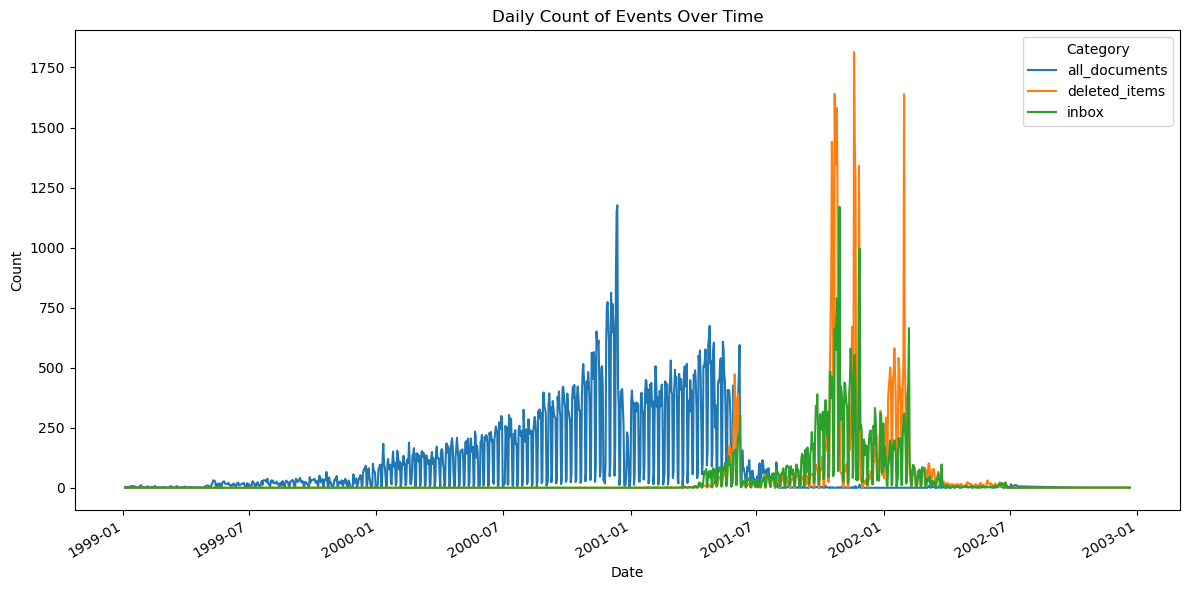

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_1999_2003 = merged_df[merged_df.date_short.dt.year.between(1999, 2003)]
daily_counts = df_1999_2003.groupby(['date_short','source']).size().unstack(fill_value=0)


daily_counts

daily_counts.plot(
    kind='line',
    figsize=(12, 6),
    title='Daily Count of Events Over Time'
)

# Add labels for clarity
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

## Observation:

1. There seem some cleaning / deletion activities coinciding with US Gov audit scrutinity (around mid 2001)
2. There is no overlapp emails from the three mailboxes sampled. We should scrape all sub folders and add to corpus
3. We don't have evidence yet that the high email deletion is due to hiding documents, 
    a. Could it be just abnormal email volume happening therefore more deletion happening?  OR
    b. Are those deleted have contents, Enron wants to hide from gov auditors?